<a href="https://colab.research.google.com/github/vongkhmer/NoteOnEfficientCPP/blob/master/MPI_DATA_FIRST_WORKING_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
mpi_link = "https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz"
!wget $mpi_link
anot_link =  "https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip"
!wget $anot_link
!tar xvzf mpii_human_pose_v1.tar.gz
!unzip mpii_human_pose_v1_u12_2.zip
!mkdir preprocessed_train
!mkdir preprocessed_val
!pip install -U tensorflow-addons

ストリーミング出力は最後の 5000 行に切り捨てられました。
./images/006644163.jpg
./images/004278327.jpg
./images/061707653.jpg
./images/046332890.jpg
./images/038161650.jpg
./images/014551548.jpg
./images/012610270.jpg
./images/030097552.jpg
./images/090687283.jpg
./images/092028594.jpg
./images/020276921.jpg
./images/086201772.jpg
./images/081240248.jpg
./images/045623651.jpg
./images/002182340.jpg
./images/009557537.jpg
./images/039847876.jpg
./images/001289747.jpg
./images/062442493.jpg
./images/020601740.jpg
./images/023538326.jpg
./images/087342324.jpg
./images/061328639.jpg
./images/045247005.jpg
./images/043498418.jpg
./images/087985677.jpg
./images/010424320.jpg
./images/024897690.jpg
./images/069923899.jpg
./images/067383796.jpg
./images/041030561.jpg
./images/033226972.jpg
./images/008849250.jpg
./images/038906071.jpg
./images/078429470.jpg
./images/084706083.jpg
./images/050972608.jpg
./images/085780094.jpg
./images/033015595.jpg
./images/088501532.jpg
./images/045915913.jpg
./images/073336151.jpg
./

In [ ]:
import json
import matplotlib.pyplot as plt
import os
from PIL import Image
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
from PIL import Image, ImageDraw, ImageOps
print(tf.__version__)
class config:
  image_input_shape = (256,256,3)
  heatmap_size = (78,78)
  heatmap_sigma = 2
  translate_length = 20
  num_joints = 16
  symetry_joint = [(0,3), (1,4), (2,5), (10,13), (11,14), (12,15)]
  batch_size = 32
  invert_prob = 0.3
  rotate_prob = 0.4
  crop_prob = 0.3
  bightness_prob = 0.3
  translate_prob = 0.4



class utils:
  @staticmethod
  def random_translate_augment(img_name, abs_joint_vector, joint_vis):
    t_x, t_y = np.random.randint(-30, 30, size =[2])
    translate_vector = np.array([[t_x] * config.num_joints, [t_y] * config.num_joints])
    original_img = Image.open(img_name)
    width, height = original_img.size
    #plot_img_with_flatten_joints(original_img, joint_vector)
    translate_img = original_img.transform(original_img.size, Image.AFFINE, (1, 0, translate_vector[0,0], 0, 1, translate_vector[1, 0]))
    translate_img = translate_img.resize(config.image_input_shape[0:2])
    translate_img_name = img_name[0:-4] + "_translate.jpg"
    abs_translate_joint_vector = abs_joint_vector - translate_vector
    translate_joint_vis = joint_vis.copy()
    #plot_img_with_flatten_joints(translate_img, translate_joint_vector)
    for i in range(config.num_joints):
        if translate_joint_vis[0,i] > 0.5:
            jpx, jpy = abs_translate_joint_vector[:,i]
            if jpx < 0 or jpx > width or jpy < 0 or jpy > height:
                translate_joint_vis[:,i] = np.zeros((1,1))
                abs_translate_joint_vector[:,i] = np.zeros((1,1))

    translate_joint_vector = 1.0 * abs_translate_joint_vector
    for i in range(config.num_joints):
        translate_joint_vector[:,i] = translate_joint_vector[:,i] / np.array([width, height])
    
    translate_img.save(translate_img_name, quality = 100)
    return translate_img_name, translate_joint_vector, translate_joint_vis

  @staticmethod
  def plot_joint(img_arr, joint_vector, joint_valid):
    if np.max(img_arr) < 2:
      img_arr = np.array(img_arr) * 255.0
      img_arr = img_arr.astype(np.uint8)
    img = Image.fromarray(img_arr)
    draw = ImageDraw.Draw(img)
    r = 5
    height, width, _ = img_arr.shape
    bombs = [[0,1],[1,2]
        ,[3,4],[4,5]
        ,[6,7],[7,8],[8,9]
        ,[10,11],[11,12]
        ,[13,14],[14,15]]
    colors = [(255,0,0),(255,0,0),
          (0,255,0),(0,255,0),
          (0,0,255),(0,0,255),(0,0,255),
          (128,128,0),(128,128,0),
          (128,0,128),(128,0,128)]
    r = 5 
    for b_id in range(len(bombs)):
      b = bombs[b_id]
      color = colors[b_id]
      x1, y1 = joint_vector[:, b[0]]
      v1 = joint_valid[0, b[0]]
      
      x2, y2 = joint_vector[:, b[1]]
      v2 = joint_valid[0, b[1]]
      
      if v1 != 0 and v2 != 0:
        draw.line((int(x1),int(y1), int(x2),int(y2)), fill = color, width = 5)
        draw.ellipse((int(x1) - r, int(y1) - r, int(x1) + r, int(y1) + r), fill = color)
        draw.ellipse((int(x2) - r, int(y2) - r, int(x2) + r, int(y2) + r), fill = color)
      elif v1 != 0:
        draw.ellipse((int(x1) - r, int(y1) - r, int(x1) + r, int(y1) + r), fill = color)
      elif v2 != 0:
        draw.ellipse((int(x2) - r, int(y2) - r, int(x2) + r, int(y2) + r), fill = color)
    plt.imshow(img)
    plt.show()

  @staticmethod
  def plot_image_hmp(img_arr, hmp):
    hmp_im = np.sum(hmp, axis=-1)
    hmp_im[hmp_im > 255] = 255
    norm = np.max(hmp_im)
    hmp_im = hmp_im.reshape((hmp_im.shape[0], hmp_im.shape[1])) / norm * 255
    hmp_im = np.stack([hmp_im, np.zeros((hmp_im.shape[0], hmp_im.shape[1])),np.zeros((hmp_im.shape[0], hmp_im.shape[1]))], axis=-1)
    hmp_im = Image.fromarray(np.uint8(hmp_im))
    hmp_im = hmp_im.resize((img_arr.shape[0], img_arr.shape[1]))
    hmp_im = np.array(hmp_im)

    mask1 = hmp_im[:,:,0] < 200
    mask1 = np.stack([mask1, mask1, mask1], axis=-1)
    mask2 = hmp_im[:,:,0] >= 200 
    mask2 = np.stack([mask2, mask2, mask2], axis=-1)
    img_arr_masked = img_arr * mask1
    plt.imshow(img_arr_masked + hmp_im * mask2)
    plt.show()
  
  @staticmethod
  def plot_image_hmp2(img_arr, hmp_c, threshold=220, detection_threshold=0.4):
    img_arr_masked = np.array(img_arr)
    for i in range(hmp_c.shape[-1]):
      hmp_im = hmp_c[:,:,i]
      hmp_im[hmp_im < detection_threshold] = 0
      norm = np.max(hmp_im)
      if norm > detection_threshold:
        hmp_im = hmp_im / norm * 255
      
      hmp_im = np.stack([hmp_im, np.zeros((hmp_im.shape[0], hmp_im.shape[1])),np.zeros((hmp_im.shape[0], hmp_im.shape[1]))], axis=-1)
      hmp_im = Image.fromarray(np.uint8(hmp_im))
      hmp_im = hmp_im.resize((img_arr.shape[0], img_arr.shape[1]))
      hmp_im = np.array(hmp_im)

      mask1 = hmp_im[:,:,0] < threshold
      mask1 = np.stack([mask1, mask1, mask1], axis=-1)
      mask2 = hmp_im[:,:,0] >= threshold
      mask2 = np.stack([mask2, mask2, mask2], axis=-1)
      img_arr_masked = img_arr_masked * mask1 + hmp_im * mask2
    plt.imshow(img_arr_masked)
    plt.show()

  @staticmethod
  def flip_back(output_flipped, matched_parts):
      '''
      ouput_flipped: numpy.ndarray(batch_size, num_joints, height, width)
      '''
      assert output_flipped.ndim == 4,\
          'output_flipped should be [batch_size, num_joints, height, width]'

      output_flipped = output_flipped[:, :, :, ::-1]

      for pair in matched_parts:
          tmp = output_flipped[:, pair[0], :, :].copy()
          output_flipped[:, pair[0], :, :] = output_flipped[:, pair[1], :, :]
          output_flipped[:, pair[1], :, :] = tmp

      return output_flipped

def fliplr_joints(joints, joints_vis, width, matched_parts):
    """
    flip coords
    """
    # Flip horizontal
    joints[:, 0] = width - joints[:, 0] - 1

    # Change left-right parts
    for pair in matched_parts:
        joints[pair[0], :], joints[pair[1], :] = \
            joints[pair[1], :], joints[pair[0], :].copy()
        joints_vis[pair[0], :], joints_vis[pair[1], :] = \
            joints_vis[pair[1], :], joints_vis[pair[0], :].copy()

    return joints*joints_vis, joints_vis

def transform_preds(coords, center, scale, output_size):
    target_coords = np.zeros(coords.shape)
    trans = get_affine_transform(center, scale, 0, output_size, inv=1)
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = affine_transform(coords[p, 0:2], trans)
    return target_coords

def get_affine_transform(center,
                        scale,
                        rot,
                        output_size,
                        shift=np.array([0, 0], dtype=np.float32),
                        inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        #print(scale)
        scale = np.array([scale, scale])
    scale_tmp = scale * 200.0
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5]) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans

def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)

def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result

def crop(img, center, scale, output_size, rot=0):
    trans = get_affine_transform(center, scale, rot, output_size)
    print(trans)

    dst_img = cv2.warpAffine(img,
                            trans,
                            (int(output_size[0]), int(output_size[1])),
                            flags=cv2.INTER_LINEAR)

    return dst_img

2.3.0


In [ ]:
!ls images | wc -l

24984


In [ ]:
train_df = pd.DataFrame({"image_path":[], "joint_vector":[], "joint_valid":[]})

img_id = 0

with open('train.json') as f:
  train_data = json.load(f)
count = 0 
for d in train_data:
  #print(d)
  print("working on image ", img_id)
  img_fn = d['image']
  center = d['center']
  center = np.array(center)
  jvis = d['joints_vis']
  joints = d['joints']
  joints = np.array(joints)
  scale = d['scale']

  if center[0] != -1:
    center[1] = center[1] + 15 * scale
    scale = scale * 1.25

  img_fn = os.path.join("images/", img_fn)
  img = cv2.imread(img_fn)

  trans = get_affine_transform(center, scale, rot = 0, output_size = config.image_input_shape)
  jv_trans = 1.0 * joints
  for i in range(joints.shape[0]):
    jv = joints[i,:]
    jv = np.hstack([jv,1])
    jv = jv.reshape([3,1])
    jv_trans[i,:] = np.matmul(trans, jv).reshape([2,])

  img_trans = cv2.warpAffine(img,trans,(config.image_input_shape[0], config.image_input_shape[1]), flags=cv2.INTER_LINEAR)

  img_trans_name = os.path.join("preprocessed_train/", "trid_" + str(img_id) + "_" + d["image"]  )
  cv2.imwrite(img_trans_name, img_trans)

  joint_vector = np.zeros([2,config.num_joints]) 
  joint_valid = np.zeros([2, config.num_joints])

  for i in range(config.num_joints):
    joint_valid[:,i] = [jvis[i], jvis[i]]
    joint_vector[:,i] = jv_trans[i,:]
  
  train_df = train_df.append({"image_path":img_trans_name, "joint_vector":joint_vector.copy(), "joint_valid":joint_valid.copy()}, ignore_index=True)


  flip_img = cv2.flip(img_trans, 1)
  flip_path = os.path.join("preprocessed_train", "trid_" + str(img_id) + "_" + "flipped_" + d["image"] )
  cv2.imwrite(flip_path, flip_img)
  flip_joint_vector = joint_vector.copy()
  flip_joint_valid = joint_valid.copy()
  for i in range(config.num_joints):
      flip_joint_vector[0,i] = config.image_input_shape[0] - flip_joint_vector[0,i]
  for fp in config.symetry_joint:
    ind1 = fp[0]
    ind2 = fp[1]
    flip_joint_vector[:, ind1], flip_joint_vector[:, ind2]  = flip_joint_vector[:, ind2].copy(), flip_joint_vector[:, ind1].copy()
    flip_joint_valid[:, ind1], flip_joint_valid[:, ind2] = flip_joint_valid[:, ind2].copy(), flip_joint_valid[:, ind1].copy()

  train_df = train_df.append({"image_path":flip_path, "joint_vector":flip_joint_vector, "joint_valid":flip_joint_valid}, ignore_index=True)
  img_id += 1


In [ ]:
val_df = pd.DataFrame({"image_path":[], "joint_vector":[], "joint_valid":[]})

img_id = 0

with open('valid.json') as f:
  val_data = json.load(f)
count = 0 
for d in val_data:
  #print(d)
  print("working on image ", img_id)
  img_fn = d['image']
  center = d['center']
  center = np.array(center)
  jvis = d['joints_vis']
  joints = d['joints']
  joints = np.array(joints)
  scale = d['scale']

  if center[0] != -1:
    center[1] = center[1] + 15 * scale
    scale = scale * 1.25

  img_fn = os.path.join("images/", img_fn)
  img = cv2.imread(img_fn)

  trans = get_affine_transform(center, scale, rot = 0, output_size = config.image_input_shape)
  jv_trans = 1.0 * joints
  for i in range(joints.shape[0]):
    jv = joints[i,:]
    jv = np.hstack([jv,1])
    jv = jv.reshape([3,1])
    jv_trans[i,:] = np.matmul(trans, jv).reshape([2,])

  img_trans = cv2.warpAffine(img,trans,(config.image_input_shape[0], config.image_input_shape[1]), flags=cv2.INTER_LINEAR)

  img_trans_name = os.path.join("preprocessed_val/", "valid_" + str(img_id) + "_" + d["image"]  )
  cv2.imwrite(img_trans_name, img_trans)

  joint_vector = np.zeros([2,config.num_joints]) 
  joint_valid = np.zeros([2, config.num_joints])

  for i in range(config.num_joints):
    joint_valid[:,i] = [jvis[i], jvis[i]]
    joint_vector[:,i] = jv_trans[i,:]
  
  val_df = val_df.append({"image_path":img_trans_name, "joint_vector":joint_vector.copy(), "joint_valid":joint_valid.copy()}, ignore_index=True)

  img_id += 1



In [ ]:
def heatchanel_to_joint(heat_channel):
  py, px = np.unravel_index(heat_channel.argmax(), heat_channel.shape)
  px = (px - heat_channel.shape[0] / 2) / heat_channel.shape[0]
  py = (py - heat_channel.shape[1] / 2) / heat_channel.shape[1]
  return px, py
def heatmap_to_joint_vector(heatmap):
  num_joints = heatmap.shape[-1]
  ans = []
  for i in range(num_joints):
    heat_channel = heatmap[:,:,i]
    px, py = heatchanel_to_joint(heat_channel)
    ans.extend([px,py])
  return np.array(ans)
test_index = -1

preprocessed_train/trid_34_flipped_068423303.jpg
[[1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(2, 16)
[[102.80075962 136.03454041 283.21271251 283.21271251 109.73968088
   78.331932    90.38374262 130.92165106 136.18361766 169.48445035
  142.24304891 133.47809574 139.32139785 112.29612556 112.66133194
  119.96545959]
 [121.40495309 171.80343454   3.44328997   3.44328997 168.88178344
  109.71834869 115.56165089  77.21498022  76.03105415  68.53833383
   92.1884421  134.18717664 159.38641737 114.83123812 102.77942733
   62.24151834]]


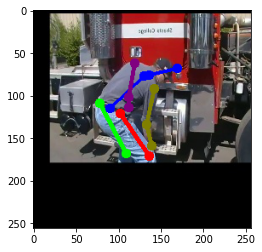

In [ ]:
test_index += 1
img = train_df.loc[test_index]["image_path"]
print(img)
img_arr = np.array(Image.open(img))
joint_vector = train_df.loc[test_index]["joint_vector"]
joint_valid = train_df.loc[test_index]["joint_valid"] 
print(joint_valid)
print(joint_vector.shape)
print(joint_vector)
utils.plot_joint(img_arr, joint_vector, joint_valid)
plt.show()

[[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.]]
(2, 16)
[[  96.06022406  118.87434973  108.83613443  140.77591038  137.12565027
   131.65026011  125.26230492 -124.78051247 -124.78051247 -124.78051247
    94.235094     89.67226887 -124.78051247 -124.78051247  153.55182076
  -124.78051247]
 [ 192.94572998  143.6672212    81.61280275   79.78767279  151.880306
   198.42111984   80.70023777 -107.28814756 -107.28814756 -107.28814756
    65.18663315   25.94633913 -107.28814756 -107.28814756   56.06098338
  -107.28814756]]


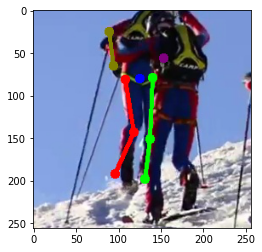

In [ ]:
test_index += 1
img = val_df.loc[test_index]["image_path"]
img_arr = np.array(Image.open(img))
joint_vector = val_df.loc[test_index]["joint_vector"]
joint_valid = val_df.loc[test_index]["joint_valid"] 
print(joint_valid)
print(joint_vector.shape)
print(joint_vector)
utils.plot_joint(img_arr, joint_vector, joint_valid)
plt.show()

In [ ]:
# @tf.function
def cust_loss(y,y_pred):
  # loss = 0.0
  # for i in range(tf.shape(y)[-1]):
  #   hmp = y[:,:,:,i]
  #   hmp_pred = y_pred[:,:,:,i]
  #   loss += 0.5 * tf.reduce_mean(tf.square(tf.subtract(hmp, hmp_pred)))
  return tf.reduce_sum(tf.reduce_mean(tf.square(tf.subtract(y, y_pred)), axis=(0,1,2))) #- 2 * loss #confirmed to be the same
  #return tf.reduce_mean(tf.square(tf.subtract(y, y_pred)))


# resnet_pretrained = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=config.image_input_shape)
# resnet_pretrained.trainable = False
# input_tensor = tf.keras.Input(shape=config.image_input_shape)
# x = tf.keras.applications.resnet50.preprocess_input(input_tensor)
# x = resnet_pretrained(x)
# x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(4,4), strides=2)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(4,4), strides=2)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(4,4), strides=2)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.ReLU()(x)
# output_heatmap = tf.keras.layers.Convolution2D(filters=16,kernel_size=(1,1))(x)
# resnet_pose_model = tf.keras.Model(inputs=input_tensor, outputs=output_heatmap)
# resnet_pose_model.summary()
# resnet_pose_model.compile(loss=cust_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))


In [ ]:
import tensorflow_addons as tfa


image_path = train_df["image_path"]
joint_vector = train_df["joint_vector"]
joint_vector = np.stack(joint_vector)
print(joint_vector.shape)
joint_valid = train_df["joint_valid"]
joint_valid = np.stack(joint_valid)

data_dict = {"image_path":image_path, "joint_vector":joint_vector, "joint_valid":joint_valid}

train_data = tf.data.Dataset.from_tensor_slices(data_dict)

val_image_path = val_df["image_path"]
val_joint_vector = val_df["joint_vector"]
val_joint_vector = np.stack(val_joint_vector)
print(val_joint_vector.shape)
val_joint_valid = val_df["joint_valid"]
val_joint_valid = np.stack(val_joint_valid)

val_data_dict = {"image_path":val_image_path, "joint_vector":val_joint_vector, "joint_valid":val_joint_valid}

train_data = tf.data.Dataset.from_tensor_slices(data_dict)
val_data = tf.data.Dataset.from_tensor_slices(val_data_dict)

# def random_invert(x, p=config.invert_prob):
#   if  tf.random.uniform([]) < p:
#     x = (255-x)
#   else:
#     x
#   return x

def random_rotate(img, hmp, p =config.rotate_prob):
  if  tf.random.uniform([]) < p:
    rotate_angle = tf.random.uniform([], -30 / 180 * 3.1416, 30 / 180 * 3.1416)
    img = tfa.image.rotate(img, rotate_angle , "BILINEAR")
    hmp = tfa.image.rotate(hmp, rotate_angle , "BILINEAR")
  return img, hmp

def random_translate(img, hmp, p=config.translate_prob):
  if tf.random.uniform([]) < p:
    translate_vector = tf.random.uniform([2,], -10, 10 )
    img = tfa.image.translate(img, translate_vector)
    translate_vector = translate_vector * config.heatmap_size[0] / config.image_input_shape[0]
    hmp = tfa.image.translate(hmp, translate_vector)
  return img, hmp

def random_brightness(img, p = config.bightness_prob):
  if  tf.random.uniform([]) < p:
    random_brightness = tf.random.uniform([], -0.2, 0.4)
    img = tf.image.adjust_brightness(img, random_brightness)
  return img

def random_center_crop(img, hmp, p = config.crop_prob):
  if  tf.random.uniform([]) < p:
    crop_fraction = tf.random.uniform([], 0.6, 1)
    if crop_fraction < 0.7:
      img = tf.image.central_crop(img, 0.6)
      hmp = tf.image.central_crop(hmp, 0.6)
    elif crop_fraction < 0.8:
      img = tf.image.central_crop(img, 0.7)
      hmp = tf.image.central_crop(hmp, 0.7)
    elif crop_fraction < 0.9:
      img = tf.image.central_crop(img, 0.8)
      hmp = tf.image.central_crop(hmp, 0.8)
    else:
      img = tf.image.central_crop(img, 0.9)
      hmp = tf.image.central_crop(hmp, 0.9)
    img = tf.image.resize(img,(config.image_input_shape[0], config.image_input_shape[1]))
    img = tf.cast(img, tf.uint8)
    hmp = tf.image.resize(hmp, (config.heatmap_size[0], config.heatmap_size[1]))
    print(hmp.shape)
    hmp = tf.reshape(hmp, [config.heatmap_size[0], config.heatmap_size[1], config.num_joints])
    print(hmp.shape)
    hmp = tf.cast(hmp, tf.float64)
  #print(tf.dtypes(img))
  return img, hmp


def preprocess_train(image_info):
  image_path = image_info["image_path"]
  joint_vector = image_info["joint_vector"]
  joint_valid = image_info["joint_valid"]
  joint_valid = tf.slice(joint_valid,[0,0],[1,config.num_joints])
  joint_valid = tf.reshape(joint_valid, [1,1,config.num_joints])
  print(joint_valid.shape)
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image_shape = tf.shape(image)
  if image_shape[-1] < 3 :
    image = tf.image.grayscale_to_rgb(image)
  x = [i for i in range(config.heatmap_size[1])]
  y = [i for i in range(config.heatmap_size[0])]
  xx,yy = tf.meshgrid(x,y)
  xx = tf.reshape(tf.cast(xx, tf.float64), (*config.heatmap_size,1))
  yy = tf.reshape(tf.cast(yy, tf.float64), (*config.heatmap_size,1)) 
  print(xx.shape)

  x = tf.floor(tf.reshape(joint_vector[0,:],[1,1,config.num_joints]) * config.heatmap_size[1] / config.image_input_shape[0] + 0.5)
  y = tf.floor(tf.reshape(joint_vector[1,:],[1,1,config.num_joints]) * config.heatmap_size[0] / config.image_input_shape[1] + 0.5)

  exist = tf.reshape(joint_valid[0,:], [1,1,config.num_joints])
  print(x.shape)
  sigma = tf.cast(config.heatmap_sigma, dtype=tf.float64)
  heatmap = tf.exp(-(((xx-x)/ sigma )**2)/2.0 -(((yy-y)/sigma)**2)/2.0) * exist
  print(heatmap.shape)

  #random invert
  # image = random_invert(image, config.invert_prob)

  #random rotate
  image, heatmap = random_rotate(image, heatmap, config.rotate_prob)

  #center crop
  image, heatmap = random_center_crop(image, heatmap, config.crop_prob)

  #random brighness
  image = random_brightness(image, config.bightness_prob)

  #random translate
  image, heatmap = random_translate(image, heatmap, config.translate_prob)
  
  return (image, joint_valid,), heatmap


def preprocess_val(image_info):
  image_path = image_info["image_path"]
  joint_vector = image_info["joint_vector"]
  joint_valid = image_info["joint_valid"]
  joint_valid = tf.slice(joint_valid,[0,0],[1,config.num_joints])
  joint_valid = tf.reshape(joint_valid, [1,1,config.num_joints])
  print(joint_valid.shape)
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image_shape = tf.shape(image)
  if image_shape[-1] < 3 :
    image = tf.image.grayscale_to_rgb(image)
  x = [i for i in range(config.heatmap_size[1])]
  y = [i for i in range(config.heatmap_size[0])]
  xx,yy = tf.meshgrid(x,y)
  xx = tf.reshape(tf.cast(xx, tf.float64), (*config.heatmap_size,1))
  yy = tf.reshape(tf.cast(yy, tf.float64), (*config.heatmap_size,1)) 
  print(xx.shape)

  x = tf.floor(tf.reshape(joint_vector[0,:],[1,1,config.num_joints]) * config.heatmap_size[1] / config.image_input_shape[1] + 0.5)
  y = tf.floor(tf.reshape(joint_vector[1,:],[1,1,config.num_joints]) * config.heatmap_size[0] / config.image_input_shape[0] + 0.5)

  exist = tf.reshape(joint_valid[0,:], [1,1,config.num_joints])
  print(x.shape)
  sigma = tf.cast(config.heatmap_sigma, dtype=tf.float64)
  heatmap = tf.exp(-(((xx-x)/ sigma )**2)/2.0 -(((yy-y)/sigma)**2)/2.0) * exist

  return (image, joint_valid,), heatmap

train_data = train_data.shuffle(buffer_size=60924, reshuffle_each_iteration=True)
train_data = train_data.map(preprocess_train, num_parallel_calls=2)
val_data = val_data.map(preprocess_val, num_parallel_calls=2)
train_data_iter = iter(train_data)
val_data_iter = iter(val_data)


(44492, 2, 16)
(2958, 2, 16)
(1, 1, 16)
(78, 78, 1)
(1, 1, 16)
(78, 78, 16)
(78, 78, 16)
(78, 78, 16)
(1, 1, 16)
(78, 78, 1)
(1, 1, 16)


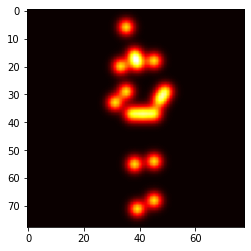

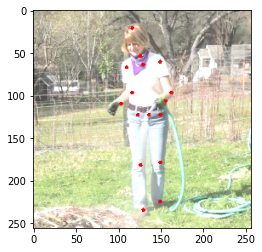

tf.Tensor([[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]], shape=(1, 1, 16), dtype=float64)


In [ ]:
(img_arr, jva), hmp = next(train_data_iter)
plt.imshow(np.sum(hmp, axis=-1), cmap="hot")
plt.show()
utils.plot_image_hmp2(img_arr.numpy(), hmp.numpy())
print(jva)

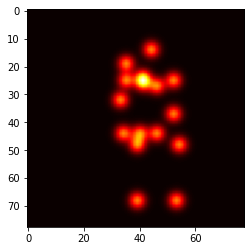

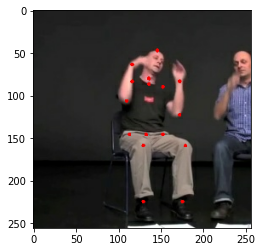

tf.Tensor([[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]], shape=(1, 1, 16), dtype=float64)


In [ ]:
(img_arr, jva), hmp = next(val_data_iter)
plt.imshow(np.sum(hmp, axis=-1), cmap="hot")
plt.show()
utils.plot_image_hmp2(img_arr.numpy(), hmp.numpy())
print(jva)

In [ ]:
train_data = train_data.batch(config.batch_size)
train_data = train_data.prefetch(2)
val_data = val_data.batch(config.batch_size)
val_data = val_data.prefetch(2)
training_hist = []
val_hist = []

In [ ]:
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     loss = logs.get('loss')
#     val_loss = logs.get('val_loss')
#     training_hist.append(loss)
#     val_hist.append(val_loss)

#     if  epoch % 10 == 0:
#       self.model.save("/content/drive/My Drive/MPII_RESNET_MODELS/resnet_locked_epoch_" + str(epoch) + ".h7")

# callback1 = MyCustomCallback()
# history = resnet_pose_model.fit(train_data, validation_data=val_data, verbose=1, initial_epoch=0, epochs=101, callbacks=[callback1])


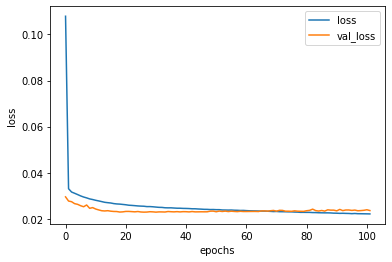

In [ ]:
plt.plot(training_hist, label="loss")
plt.plot(val_hist, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


In [ ]:
# resnet_pretrained.trainable = True
# resnet_pose_model.compile(loss=cust_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))

# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     loss = logs.get('loss')
#     val_loss = logs.get('val_loss')
#     training_hist.append(loss)
#     val_hist.append(val_loss)

#     if  epoch % 10 == 0:
#       self.model.save("/content/drive/My Drive/MPII_RESNET_MODELS/resnet_retuned_epoch_" + str(epoch) + ".h5")



In [ ]:
history = resnet_pose_model.fit(train_data, validation_data=val_data, verbose=1, initial_epoch=67, epochs=120, callbacks=[callback1])


Epoch 68/120
1391/1391 [==============================] - 422s 304ms/step - loss: 0.0119 - val_loss: 0.0183
Epoch 69/120
1391/1391 [==============================] - 423s 304ms/step - loss: 0.0117 - val_loss: 0.0177
Epoch 70/120
1391/1391 [==============================] - 422s 303ms/step - loss: 0.0116 - val_loss: 0.0177
Epoch 71/120
1391/1391 [==============================] - 425s 306ms/step - loss: 0.0114 - val_loss: 0.0180
Epoch 72/120
1391/1391 [==============================] - 421s 303ms/step - loss: 0.0114 - val_loss: 0.0197
Epoch 73/120
1391/1391 [==============================] - 422s 303ms/step - loss: 0.0113 - val_loss: 0.0185
Epoch 74/120
1391/1391 [==============================] - 422s 304ms/step - loss: 0.0112 - val_loss: 0.0175
Epoch 75/120
1391/1391 [==============================] - 422s 303ms/step - loss: 0.0110 - val_loss: 0.0187
Epoch 76/120
1391/1391 [==============================] - 422s 303ms/step - loss: 0.0110 - val_loss: 0.0182
Epoch 77/120
1391/1391 [====

In [ ]:
loaded_resnet_model = tf.keras.models.load_model("/content/drive/My Drive/MPII_RESNET_MODELS/resnet_locked_epoch_90.h5", compile=False)

In [ ]:
train_data_iter = iter(train_data)
val_data_iter = iter(val_data)

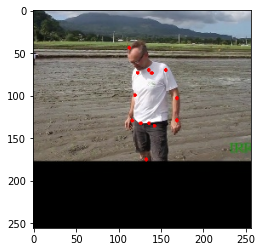

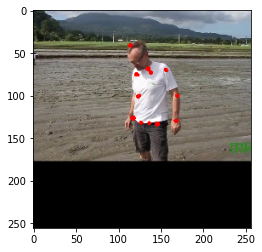

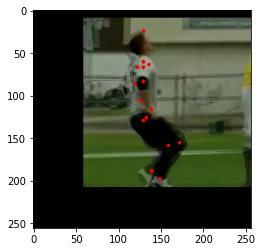

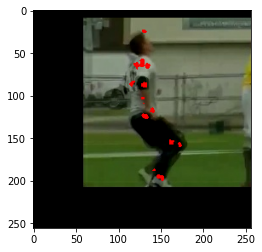

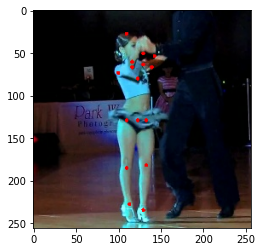

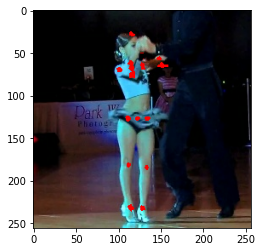

In [ ]:
X, tst_hmp = next(train_data_iter)
tst_img, jva = X
utils.plot_image_hmp2(np.array(tst_img[0]), np.array(tst_hmp[0]))
pred = loaded_resnet_model.predict(X)

utils.plot_image_hmp2(np.array(tst_img[0]), np.array(pred[0]), detection_threshold=0.4)
plt.show()

X, tst_hmp = next(train_data_iter)
tst_img, jva = X
utils.plot_image_hmp2(np.array(tst_img[0]), np.array(tst_hmp[0]))
pred = loaded_resnet_model.predict(X)

utils.plot_image_hmp2(np.array(tst_img[0]), np.array(pred[0]), detection_threshold=0.4)
plt.show()

X, tst_hmp = next(train_data_iter)
tst_img, jva = X
utils.plot_image_hmp2(np.array(tst_img[0]), np.array(tst_hmp[0]))
pred = loaded_resnet_model.predict(X)

utils.plot_image_hmp2(np.array(tst_img[0]), np.array(pred[0]), detection_threshold=0.4)
plt.show()

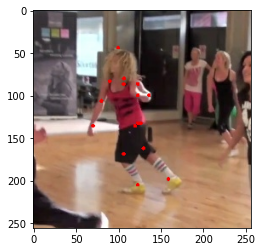

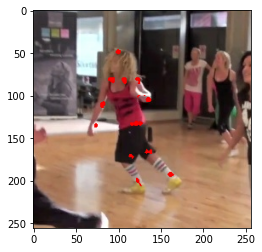

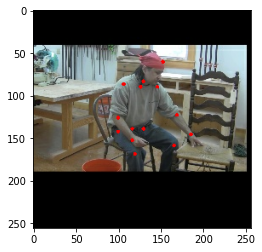

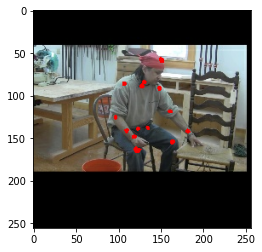

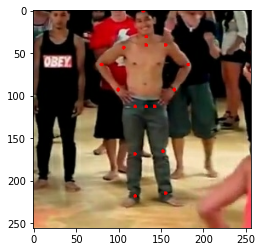

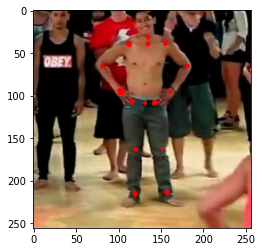

In [ ]:
X, tst_hmp = next(val_data_iter)
tst_img, jva = X
utils.plot_image_hmp2(np.array(tst_img[0]), np.array(tst_hmp[0]))
pred = loaded_resnet_model.predict(X)

utils.plot_image_hmp2(np.array(tst_img[0]), np.array(pred[0]), detection_threshold=0.4)
plt.show()

X, tst_hmp = next(val_data_iter)
tst_img, jva = X
utils.plot_image_hmp2(np.array(tst_img[0]), np.array(tst_hmp[0]))
pred = loaded_resnet_model.predict(X)

utils.plot_image_hmp2(np.array(tst_img[0]), np.array(pred[0]), detection_threshold=0.4)
plt.show()

X, tst_hmp = next(val_data_iter)
tst_img, jva = X
utils.plot_image_hmp2(np.array(tst_img[0]), np.array(tst_hmp[0]))
pred = loaded_resnet_model.predict(X)

utils.plot_image_hmp2(np.array(tst_img[0]), np.array(pred[0]), detection_threshold=0.4)
plt.show()

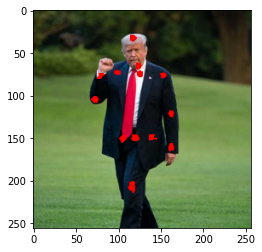

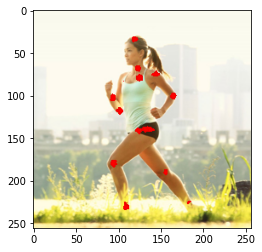

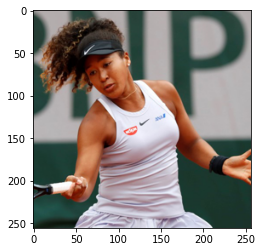

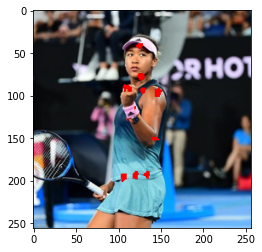

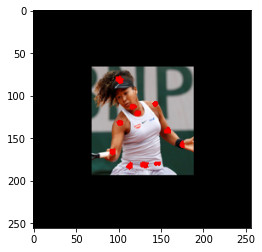

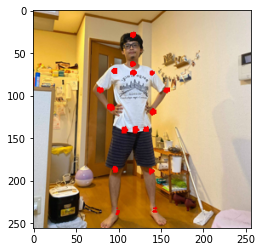

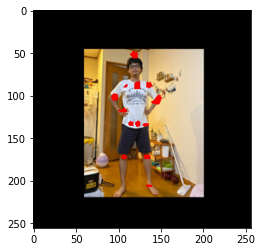

In [ ]:
test_num = 7
for i in range(1, test_num+1):
  tst_img = "testimag" + str(i) + ".jpg"
  img_arr = Image.open(tst_img)
  img_arr = img_arr.resize([config.image_input_shape[0], config.image_input_shape[1]])
  img_arr = np.array(img_arr).reshape((1, config.image_input_shape[0], config.image_input_shape[1], config.image_input_shape[2]))
  joint_bool = np.ones([1, config.num_joints])
  pred = loaded_resnet_model.predict((img_arr, joint_bool))

  utils.plot_image_hmp2(img_arr[0], np.array(pred[0]), threshold=230, detection_threshold=0.5)
  plt.show()

In [ ]:
resnet_pose_model.compile(loss=cust_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
history = resnet_pose_model.fit(train_data, validation_data=val_data, verbose=1, initial_epoch=120, epochs=50, callbacks=[callback1])
